# Dataset: Trackster neighborhood with PU

- select a trackster having at least 50% of the simtrackster energy (0.5 from the associator) and energy above 10GeV
- connect its barycenter to (0,0,0), that gives the trackster axis
- draw a cylinder along this axis, 10cm wide, going 3 layers (or 10cm) before and after the first/last layer-cluster
- connect to all tracksters with a barycenter within this cone (star-like labels)
- labels based on the associator score (can even be binary)
- start with photons, 90% of them are fine, we just wanna fix the remaining 10%
- if we are doing well here, we can go to pions which are much more fragmented
- cut off at 0.2 but can include events with no edges too

Physics evaluation
- plug it into the CMSSW

Method evaluation
- based on precision and recall
    - precision: 2 LC from RECO (within the cone?) also together in SIM
        - how much mess I got in?
    - recall: 2 LC from SIM together in RECO
        - how good did I do on the connecting?


In [42]:
import uproot
import numpy as np

import matplotlib.pyplot as plt

from torch_geometric.data import Data

from reco.dataset import FEATURE_KEYS, build_pair_tensor

ds_name = "CloseByGamma200PU"
file_name = "new_ntuples_15295178_20.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
graph = uproot.open({file_path: "ticlNtuplizer/graph"})


reco2sim_index_ = associations["tsCLUE3D_recoToSim_SC"].array()
reco2sim_shared_ = associations["tsCLUE3D_recoToSim_SC_sharedE"].array()
reco2sim_score_ = associations["tsCLUE3D_recoToSim_SC_score"].array()

raw_energy_ = tracksters["raw_energy"].array()
sim_raw_energy_ = simtracksters["stsSC_raw_energy"].array()

barycenter_x_ = tracksters["barycenter_x"].array()
barycenter_y_ = tracksters["barycenter_y"].array()
barycenter_z_ = tracksters["barycenter_z"].array()

vertices_x_ = tracksters["vertices_x"].array()
vertices_y_ = tracksters["vertices_y"].array()
vertices_z_ = tracksters["vertices_z"].array()
vertices_energy_ = tracksters["vertices_energy"].array()

In [43]:
def get_representative_points(bx, by, bz, min_z, max_z):
    # take a line (0,0,0), (bx, by, bz) -> any point on the line is t*(bx, by, bz)
    # compute the intersection with the min and max layer
    # beginning of the line: (minx, miny, minz) = t*(bx, by, bz)
    # minx = t*bx
    # miny = t*by
    # minz = t*bz : t = minz / bz
    t_min = min_z / bz
    t_max = max_z / bz
    x1 = np.array((t_min * bx, t_min * by, min_z))
    x2 = np.array((t_max * bx, t_max * by, max_z))
    return x1, x2


def get_tracksters_in_cone(x1, x2, barycentres, radius=15):
    in_cone = []
    for i, x0 in enumerate(barycentres):
        # barycenter between the first and last layer
        if x0[2] > x1[2] - radius and x0[2] < x2[2] + radius:
            # distance from the particle axis less than 10cm
            d = np.linalg.norm(np.cross(x0 - x1, x0 - x2)) / np.linalg.norm(x2 - x1)
            if d < radius:
                in_cone.append((i, d))
    return in_cone

def process_PU_event(
    reco2sim,
    sim_raw_energy,
    score_threshold=0.3,
):
    # assuming only one simtrackster to keep things easy
    big = None
    little = []

    for recoT_idx, (sim_indexes, shared_energies, scores) in enumerate(reco2sim):
        for simT_idx, shared_energy, score in zip(sim_indexes, shared_energies, scores):
            # 2 goals here: 
            # - find the trackster with >50% shared energy
            # - find the tracksters with < 0.2 score
            if score > score_threshold: continue

            st_energy = sim_raw_energy[simT_idx]
            st_fraction = shared_energy / st_energy

            if st_fraction > 0.5:
                big = recoT_idx
            else:
                little.append(recoT_idx)

    return big, little

In [52]:
dataset = []

# starting pairwise
for eid in range(len(vertices_z_)):
    vertices_z = vertices_z_[eid]
    barycenter_x = barycenter_x_[eid]
    barycenter_y = barycenter_y_[eid]
    barycenter_z = barycenter_z_[eid]

    reco2sim_score = reco2sim_score_[eid]

    bigT, smallTs = process_PU_event(
        zip(reco2sim_index_[eid], reco2sim_shared_[eid], reco2sim_score),
        sim_raw_energy_[eid],
    )

    if not bigT:
        continue

    min_z = min(vertices_z[bigT])
    max_z = max(vertices_z[bigT])
    
    barycentres = np.array((barycenter_x, barycenter_y, barycenter_z)).T

    x1, x2 = get_representative_points(
        barycenter_x[bigT],
        barycenter_y[bigT], 
        barycenter_z[bigT],
        min_z,
        max_z
    )

    in_cone = get_tracksters_in_cone(x1, x2, barycentres)

    trackster_features = list([
        tracksters[k].array()[eid] for k in FEATURE_KEYS
    ])

    for recoTxId, distance in in_cone:
        # get features for each reco trackster... pairwise?
        # graph-wise?
        # start pairwise (look at BiPartite Graphs in Pytorch Geometric)
        if recoTxId == bigT:
            continue    # do not connect to itself

        features = build_pair_tensor((bigT, recoTxId), trackster_features)
        features.append(distance)
        features.append(len(vertices_z[bigT]))
        features.append(len(vertices_z[recoTxId]))

        label = 1 - reco2sim_score[recoTxId][0]

        dataset.append((features, label))

In [64]:
#len(dataset)
sum(np.array([d[1] for d in dataset]) > 0.5)

18

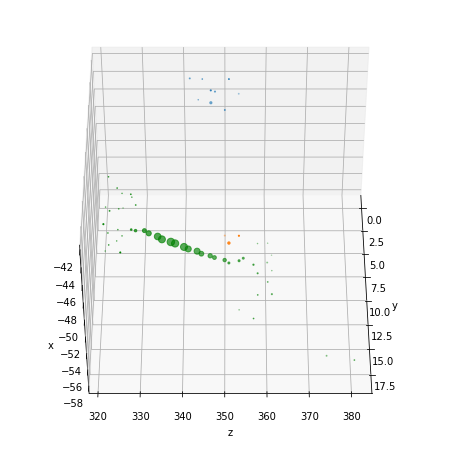

In [28]:
vertices_x = vertices_x_[eid]
vertices_y = vertices_y_[eid]
vertices_z = vertices_z_[eid]
vertices_e = vertices_energy_[eid]

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(vertices_x[bigT], vertices_y[bigT], vertices_z[bigT], s=vertices_e[bigT]*2, c="green")

for smallT in smallTs:
    ax.scatter(vertices_x[smallT], vertices_y[smallT], vertices_z[smallT], s=vertices_e[smallT]*10)

ax.view_init(45, 0, "x")
plt.show()

In [6]:
np.sqrt((42.27534103393555 - -43.609215)**2 + (26.828041076660156 - -122.22627)**2)

172.02716243571533